# Building a Word Associations Game with Data Science and NLP

The goal of this project is to explore how techniques from **Data Science** and **Natural Language Processing (NLP)** can be applied to create a **word associations game**.

<img src="../assets/word-game.png" alt="Game" style="width: 800px;"/>


Along the way, we’ll cover key NLP concepts such as:

* Word embeddings
* Embedding models
* Training an embedding model (Word2Vec)
* Calculating embedding similarity


## Part A: Theory

Before building the actual game, we need to understand the theory that powers it. The following section is adapted from my [blog post about vector databases](https://filip-melka.github.io/blog/posts/building-vector-db/).

### Embeddings

Let’s start with a simple example.

Consider the four words:

* “man”
* “woman”
* “boy”
* “girl”

Imagine plotting these words on a graph where the **x-axis** represents *gender* and the **y-axis** represents *age*. Each word would appear as a point in this 2D space.

<img src="../assets/semantic-space.png" alt="Semantic Space" style="width: 800px;"/>

Here, *gender* and *age* act as **semantic features** — numerical dimensions that capture part of each word’s meaning.

Now, let’s add another word: “king.” It’s similar in gender and age to “man,” but clearly differs in meaning. To represent this distinction, we can introduce another semantic feature — say, *royalty*.

With this third axis, our words now live in a **3D semantic space**.

<img src="../assets/coordinates.png" alt="Coordinates" style="width: 800px;"/>

Each word can now be represented by three numbers: *age*, *gender*, and *royalty*. This numerical representation — a **vector** — is what we call an **embedding**.

Of course, three dimensions aren’t nearly enough to capture the richness of language. Real-world embedding models operate in **hundreds or even thousands of dimensions**. For example, OpenAI’s `text-embedding-3-large` model generates embeddings with **3,072 dimensions**.

The real power of embeddings is that they allow us to **compare meanings mathematically**, just like we compare positions in physical space.

### Measuring Similarity

Once words are represented as vectors, we can measure how similar they are. Two common metrics are **Euclidean distance** and **cosine similarity**.

#### Euclidean Distance

Euclidean distance measures the “straight-line” distance between two points in space. It’s intuitive and based on the Pythagorean theorem:

<img src="../assets/pythagorean.png" alt="Pythagorean theorem" style="width: 800px;"/>

In Python, it can be calculated using `NumPy`:

In [5]:
import numpy as np

def euclidean_distance(vector1, vector2):
    return np.linalg.norm(vector1 - vector2)

While intuitive, Euclidean distance is less effective in high-dimensional spaces, where the concept of “distance” becomes less meaningful. That’s why **cosine similarity** is often preferred for text embeddings.

#### Cosine Similarity

Cosine similarity measures the **angle** between two vectors, ignoring their magnitudes.

In other words:

* Euclidean distance asks, *“How far apart are these points?”*
* Cosine similarity asks, *“Are these vectors pointing in the same direction?”*

This is especially useful in NLP, where the **direction** of a word vector captures meaning more reliably than its length.

The cosine similarity score ranges from **-1 to 1**, with higher values indicating greater similarity. In practice, embeddings usually fall between **0 and 1**, since negative similarity (opposite meanings) is rare.

Using `NumPy`, we can compute cosine similarity as follows:

In [6]:
def cosine_sim(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

In this project, we’ll use cosine similarity to score players’ guesses in the word association game.


## Part B: Training an Embedding Model

Now that we understand how embeddings work, let’s train one ourselves using **Word2Vec** — one of the earliest and most influential embedding techniques.

Developed by **Tomas Mikolov** and his team at Google in 2013, Word2Vec learns to represent words as vectors based on the contexts in which they appear.

### Dataset

We’ll use a collection of Wikipedia articles available through Hugging Face:

In [7]:
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
import os

MODEL_PATH = "word2vec.model"

if not os.path.exists(MODEL_PATH):
    # https://huggingface.co/datasets/wikimedia/wikipedia
    dataset = load_dataset("wikimedia/wikipedia", "20231101.en", split="train")

    training_words = []

    # Use the first 5,000 articles for demonstration
    for article in dataset["text"][:5000]:
        for sent in sent_tokenize(article):
            tokens = [word.lower() for word in word_tokenize(sent.lower())]
            if tokens:
                training_words.append(tokens)

⚠️ **Note:** Real-world models are trained on billions of words. We use 5,000 articles here for simplicity and speed.

### Training the Model

We can now train a Word2Vec model using the **CBOW (Continuous Bag of Words)** approach via the `gensim` library. Each word will be represented as a 100-dimensional vector:

In [8]:
import gensim

if os.path.exists(MODEL_PATH):
    from gensim.models import Word2Vec
    model = Word2Vec.load(MODEL_PATH)
else:
    # Build a model using the CBOW approach
    model = gensim.models.Word2Vec(
        sentences=training_words,
        vector_size=100,
        window=5,
        min_count=5,
        seed=42
    )

    model.save("word2vec.model")

After training, we can retrieve embeddings for any word (or token). The following function will help us visualize the embeddings:

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_embedding_heatmap(embeddings, labels=None, title=None, figsize=(12, 2), cmap="coolwarm"):
    # Handle 1D embeddings
    if embeddings.ndim == 1:
        embeddings = embeddings.reshape(1, -1)
    
    # Default labels
    if labels is None:
        labels = [f"Item {i}" for i in range(embeddings.shape[0])]
    
    plt.figure(figsize=figsize)
    sns.heatmap(
        embeddings,
        cmap=cmap,
        cbar_kws={'label': 'Value'},
        xticklabels=10,          # show every 10th dimension
        yticklabels=labels
    )
    plt.xlabel("Embedding Dimension")
    plt.ylabel("")
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

Let's turn the word *"sun"* into an embedding:

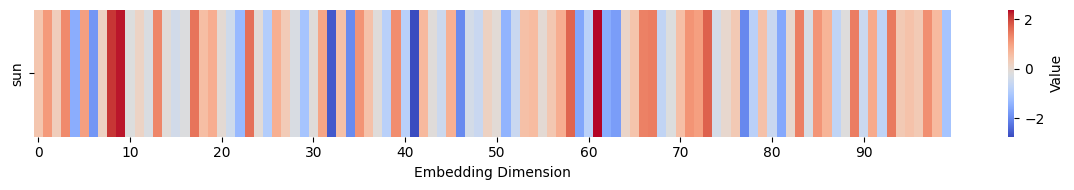

In [10]:
word = "sun"
sun_embedding = model.wv[word]
plot_embedding_heatmap(sun_embedding, labels=[word])

Now, let's try comparing the word "sun" with "moon" and "boat" using both Euclidean distance and Cosine similarity:

In [14]:
moon_embedding = model.wv["moon"]
boat_embedding = model.wv["boat"]

print("Sun - Moon")
print(f"Euclidean distance: {euclidean_distance(sun_embedding, moon_embedding)}")
print(f"Cosine similarity: {cosine_sim(sun_embedding, moon_embedding)}")
print()
print("Sun - Boat")
print(f"Euclidean distance: {euclidean_distance(sun_embedding, boat_embedding)}")
print(f"Cosine similarity: {cosine_sim(sun_embedding, boat_embedding)}")

Sun - Moon
Euclidean distance: 9.119643211364746
Cosine similarity: 0.6887038350105286

Sun - Boat
Euclidean distance: 11.610834121704102
Cosine similarity: 0.13132111728191376


As you can see, the Euclidean distance between *sun* and *moon* is **smaller** than between *sun* and *boat*. Furthermore, the cosine similarity between *sun* and *moon* is **larger** than between *sun* and *boat*. This means that the words *sun* and *moon* are semantically more related than *sun* and *boat* (as we would expect).

We will use this in our game, where we score the guessed words based on Cosine similarity with the target word.

## Part C: Building the Game

Now that we understand embeddings and similarity, let’s apply this knowledge to build a **word associations game**.

### Game Rules

* You’re given a **target word**.
* You enter four **associations** — words you think are related.
* Each guess is scored based on its **cosine similarity** to the target.
* After four guesses, you receive a new target word.
* If a guess is too dissimilar, you lose one **health point**.
* The game ends after three lost health points.

### Tech Stack

* **Next.js** — frontend framework
* **Tailwind CSS** — UI styling
* **OpenAI Embedding Model (`text-embedding-3-small`)** — used for real-time similarity scoring

Although we trained our own model earlier, OpenAI’s embeddings are larger, faster, and better suited for interactive applications.

### Choosing Target Words

We’ll use a list of 500 of the most common nouns from the [**Brown Corpus**](https://en.wikipedia.org/wiki/Brown_Corpus). Here’s how we generate and save them:

In [12]:
from nltk.corpus import brown
from nltk import pos_tag
from collections import Counter
import nltk, json

nltk.download('brown')
nltk.download('averaged_perceptron_tagger_eng')

words = brown.words()
tagged = pos_tag(words)

nouns = [w.lower() for w, pos in tagged if pos in ('NN', 'NNS')]
freq_nouns = [w for w, _ in Counter(nouns).most_common(500)]

with open("nouns.json", "w") as f:
    json.dump(freq_nouns, f, indent=2)

print(f"✅ Saved {len(freq_nouns)} nouns to nouns.json")

[nltk_data] Downloading package brown to /home/filip/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/filip/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


✅ Saved 500 nouns to nouns.json


We then use this `nouns.json` file as the source for our target words.

## Final Result

The completed game lets you explore how word meanings relate in vector space — and turns semantic similarity into an interactive challenge.

👉 **You can try the game [here](https://semantiq.vercel.app/)!**

**In summary:**
This project combines theoretical NLP concepts with hands-on implementation, showing how embeddings and cosine similarity can power creative, language-driven applications. By gamifying these ideas, we make the abstract world of vectors tangible — and fun.